# Colab Filtering Demo

### Import dependencies

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import Preprocessor
from mapping import Mapper
from topk_cf import TopKNeighborCF
from similarity import Similarity

### Data analysis

In [2]:
# Method to get file from data
def from_data(fname: str):
    data_path = os.path.abspath("../../../data")
    return os.path.join(data_path, fname)

##### Overview

In [5]:
ratings = pd.read_csv(from_data("kaggle/recommendations.csv"))
ratings.insert(
    4, "ratings",
    [Preprocessor.assign_rating(hour, rec)
    for (hour, rec) in zip(ratings["hours"], ratings["is_recommended"])],
)

In [6]:
n_ratings = len(ratings)
n_games = ratings["app_id"].nunique()
n_users = ratings["user_id"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique games: {n_games}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per game: {round(n_ratings/n_games, 2)}")
print(f"Mean global rating: {round(ratings["ratings"].mean(),2)}")

Number of ratings: 41154794
Number of unique games: 37610
Number of unique users: 13781059
Average number of ratings per user: 2.99
Average number of ratings per game: 1094.25
Mean global rating: 4.1


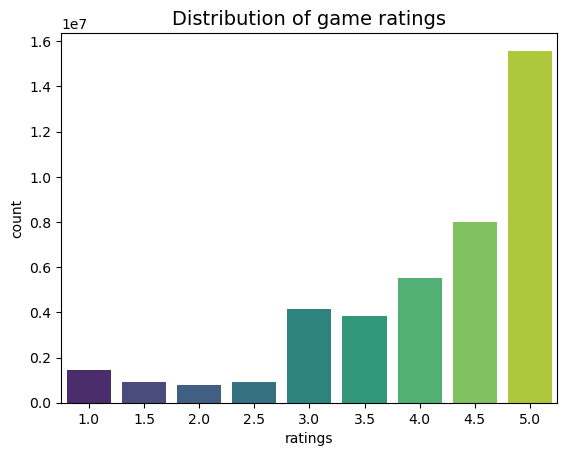

In [7]:
sns.countplot(x="ratings", data=ratings, palette="viridis")
plt.title("Distribution of game ratings", fontsize=14)
plt.show()

##### Most rated games

In [10]:
game_stats = ratings.groupby("app_id")["ratings"].agg(["count", "mean"])
game_stats.sort_values(by=["count", "mean"], ascending=False).head()

,count,mean
app_id,,
440,319492,4.628787
252490,270684,4.542034
1091500,226414,4.303879
730,219737,4.645519
570,216914,4.442062


### Preprocess data

##### Generate data from source

In [3]:
!python preprocessing.py 60

Loading data from source  Done
Filtering recommendations Done
Filtering users           Done -> 25217 users
Filtering games           Done -> 36014 games
Filtering metadata        Done -> 36014 dicts
Generating mapping        Done
Generating data           Done


##### Import from txt

In [11]:
# X: Array of user-item pairs
# y: Corresponding ratings for each user-item pair in
# M: Mapping consists of 5 dictionaries:
#    user_to_index, index_to_user, item_to_index, index_to_item, item_to_name
# ui_shape: tuple of (num_users, num_items)
X, y, ui_shape = Preprocessor.load_data(from_data("steam_60/user_item_data.txt"))
M = Mapper(from_data("steam_60/mapping.json"))
print("User-Item:", ui_shape)

User-Item: (25217, 36014)


##### Option for spliting data

In [7]:
X_train, y_train, X_test, y_test = Preprocessor.split(X, y, 0.8, shuffle=True)

### Load data into model

In [8]:
sim_func = Similarity.cosine
cf_model = TopKNeighborCF(sim_func, mode="uucf", neighbors=10)
cf_model.fit(X_train, y_train, ui_shape)

### Get prediction

In [9]:
y_pred = cf_model.predict(X_test)
print("True:", y_test)
print("Pred:", y_pred)

True: [4.  4.5 3.  ... 4.  4.5 4. ]
Pred: [3.43411672 4.44506491 4.20355997 ... 3.66763465 4.24948626 3.61374996]


### Evaluation

In [10]:
from sklearn.metrics import r2_score, mean_squared_error
print("R2  :", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R2  : 0.3010752153860604
RMSE: 0.9769705268188834


### Get recommendations for an user

In [11]:
user_idx = np.random.randint(cf_model.num_users)
user = M.index_to_user[str(user_idx)]
print(f"Picked user: {user}")

Picked user: 726528


In [12]:
games, ratings = cf_model.get_recommendation(user_idx, 10)
app_ids = [M.index_to_item[str(i)] for i in games]
titles = [M.item_to_name[str(i)] for i in app_ids]
rec = pd.DataFrame({"app_id": app_ids, "titles": titles, "rating": ratings})
rec

,app_id,titles,rating
0,243890,Mavis Beacon Teaches Typing Family Edition,6.977656
1,1265970,Dark City: Dublin Collector's Edition,6.909213
2,770200,Squally,6.879627
3,1803150,Void Slayer,6.876066
4,401250,Zulu Response,6.851001
5,673830,VR STOCK CAR RACERS,6.814325
6,1194790,Kessler Effect,6.788010
7,877780,Puzzles for smart: Cats,6.772220
8,852180,Bunker Rush,6.766864
9,1630180,The hidden game society,6.762762
